In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline




In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
block_size = 3 # 通过三个字符 预测 下一个   上下文大小？
X, Y = [], []
for w in words[:3]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X) # dim = [sample, block_size]
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words) # 随机打乱
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# 数据集通常被划分为训练集、开发集（也称验证集）和测试集
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# 一个字符 经过 one_hot 编码 27维的向量 
# 根据向量 1 的位置  在 C （查询表）中 得到 二维的emb 
C = torch.randn((27, 2))
X.shape,C.shape

(torch.Size([16, 3]), torch.Size([27, 2]))

In [13]:
# 不仅可以使用C[index] 获取index行  可以使用C[indexList]  获取多行 indexList
data = C[[1,2,3]] # [3, 2]
data,data.shape

(tensor([[-0.6601,  1.6165],
         [-0.7620,  1.1801],
         [ 1.4084, -0.8714]]),
 torch.Size([3, 2]))

In [15]:
# C 查询表 做 embing
emb = C[X]
# 每个样本 有 block_size 个字符  作为上文  每个字符 映射成 2维的向量
emb.shape   # [sample, block_size, embdim]   #  


torch.Size([16, 3, 2])

In [17]:
# 第一层  即 隐藏层
W1 = torch.randn((6, 100))  # 神经元 输入 有 3 * 2       100 个神经元
b1 = torch.randn(100)

In [20]:
# pyTorch 张量是连续存储的。这意味着数据在内存中是按行优先（row-major order）顺序排列的
# 也就是说，第一个维度的元素是连续的，然后是第二个维度的元素，以此类推。
emb.view(-1,6).shape    # 这种是没有 内存拷贝  高效做法

# torch.cat()
# torch.unbind()

torch.Size([16, 6])

In [23]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([16, 100])

In [24]:
# 输出层  输出 27 向量
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [25]:
logits = h @ W2 + b2

In [26]:
logits.shape

torch.Size([16, 27])

In [27]:
counts = logits.exp()
prob = counts / counts.sum(1,keepdim=True)
prob.shape

torch.Size([16, 27])

In [28]:
loss = -prob[torch.arange(16),Y].log().mean() 
loss

tensor(16.7824)

In [36]:
# ------------ now made respectable :) ---------------
Xtr.shape, Ytr.shape # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [46]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)  #  embeding =  10   embeding = 2 影响质量
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [90]:

# 通过 跟踪 学习率（超参数）  绘制图形，确定一个良好的学习率
lre = torch.linspace(-3, 0, 1000) # 作为指数 10** -3 ~ 1
lrs = 10**lre
lri = []
lossi = []
stepi = [] 
  

In [91]:
batch = 32
torch.randint(0,100,(batch,))

tensor([36, 58, 53, 59, 39, 84, 18, 22, 92, 96, 33, 21, 12, 37, 26, 68, 89, 73,
        58, 99, 77, 44, 82, 89, 54, 16, 57,  4, 87, 91, 87, 58])

In [92]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())  

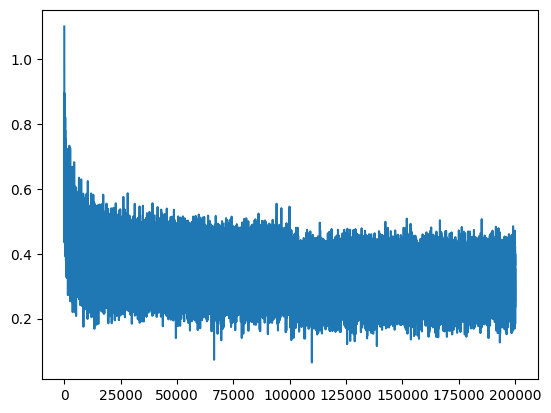

In [93]:
# 跳值的
plt.plot(stepi, lossi)

In [95]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1080, grad_fn=<NllLossBackward0>)

In [96]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1623, grad_fn=<NllLossBackward0>)

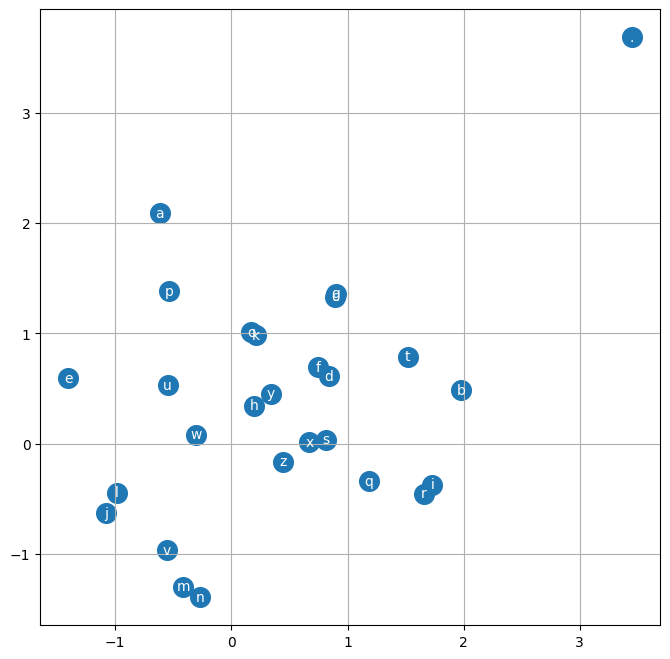

In [97]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)  # 这里只有 2维  实际上 embeding = 10
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [98]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [99]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
kayanna.
elve.
hayla.
rensleighdraig.
adee.
daeliah.
milopi.
eden.
esmana.
sephzion.
kamin.
shubergiaghiel.
kendreelle.
jettunfiun.
kaveer.
yaque.
els.
kayshaston.
azhia.


学习 理解


In [33]:
sum(p.nelement() for p in parameters) # number of parameters in total
# len(parameters) 不能这么用

11897

In [81]:
X = torch.randint(0,100,(10,2))
X

tensor([[46,  0],
        [77, 94],
        [76, 41],
        [45, 96],
        [33, 26],
        [86, 97],
        [27, 62],
        [10, 54],
        [ 1, 14],
        [87, 14]])

In [82]:
X[[1,2]]

tensor([[77, 94],
        [76, 41]])

In [85]:
lre = torch.linspace(-3, 0, 1000) # 作为指数 10** -3 ~ 1
lrs = 10**lre
lre.shape


torch.Size([1000])